**DATA PATHS**

In [0]:
# Input data path
root_d = '/content/gdrive/' # the path of parking_dataset


orgin_dir = root_d + 'parking_dataset/'
#orgin_dir = root_d + 'Download_data_example_1/'
train_dir = orgin_dir + "CNR-EXT-Patches-150x150/train_small"
validation_dir = orgin_dir + "CNR-EXT-Patches-150x150/validation_small"
test_dir = orgin_dir + "CNR-EXT-Patches-150x150/test_small"

# Building Classifly Model

### Our new Model

In [0]:
### ------------------------ start Define loss function ------------------------
import dill
import tensorflow as tf
from keras import backend as K

def binary_focal_loss(gamma=2., alpha=.25):
    """
    model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], optimizer=optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # Clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return binary_focal_loss_fixed
### ------------------------ end Define loss function ------------------------

In [0]:
# building network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import optimizers

model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))            
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D(padding=(1, 1), data_format=None))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D(padding=(1, 1), data_format=None))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5, noise_shape = None, seed = None))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss=[binary_focal_loss(alpha=.45, gamma=1.5)],
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

# Training model

In [0]:
# Data Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# the path of train dataset with generated images
train_dir = save_path + 'train'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,#20
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,#20
        class_mode='binary')

Found 5000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
import time
from glob import glob
# Perform the training (fit the model with train and validation data)
def num_of_train_steps(path, batch_size):
    num = glob(path + '/busy/*')
    num += glob(path + '/free/*')
    return int(len(num)/batch_size)
    
model_name = '/content/gdrive/65test.h5'

# Set the model saving settings
# while val_acc not improve in 5 epoches, it will be stop immediately
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) 
# Only save the best val_acc model
mc = ModelCheckpoint(model_name, monitor='val_acc', verbose=1, save_best_only=True,
                            save_weights_only=False, mode='auto', period=1)
cb_list = [mc, es]

starttime = time.time()
history = model.fit_generator(
      train_generator,
      steps_per_epoch= num_of_train_steps(train_dir, 20), # 5000/20=250
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=cb_list) # 1000/20=50
print('Total time: %s (min)'%str((time.time()-starttime)/60.))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.0483 - acc: 0.9156 
Epoch 00001: val_acc improved from -inf to 0.28200, saving model to /content/gdrive/65test.h5
250/250 [==============================] - 5014s 20s/step - loss: 0.0483 - acc: 0.9156 - val_loss: 0.7169 - val_acc: 0.2820
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.0334 - acc: 0.9454
Epoch 00002: val_acc improved from 0.28200 to 0.90400, saving model to /content/gdrive/65test.h5
250/250 [==============================] - 15s 60ms/step - loss: 0.0334 - acc: 0.9454 - val_loss: 0.0482 - val_acc: 0.9040
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.0261 - acc: 0.9564
Epoch 00003: val_acc improved from 0.90400 to 0.96500, saving model to /content/gdrive/65test.h5
250/250 [==============================] - 14s 56ms/step - loss: 0.0261 - acc: 0.9564 - val_loss: 0.0237 - val_acc:

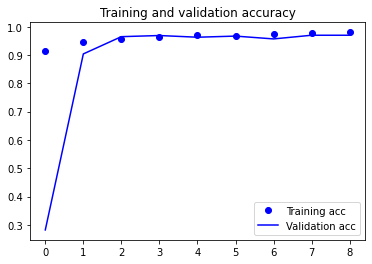

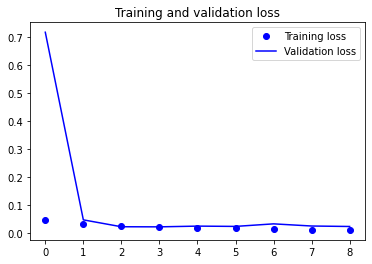

In [0]:
# Plot the accuracies and losses in model training
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()